# Tutorial on Penalized Trust Region (PTR) Algorithm - Successive Convex-Optimization

## 1: System Dynamics

Assume we have a system with the state $x = [r,v] \in\mathbb{R}^4$ characterized by the following nonlinear dynamics:

$$ \begin{align} \dot{r} &= v \\ \dot{v} &= -D + u \end{align}$$
where $D=\frac{1}{2}C_D\lVert v\rVert ^2\hat{v}$ is a drag force, $\hat{v}=\frac{v}{\lVert v\rVert}$, and $u\in\mathbb{R}^n$ is the control.

Let's try to setup an optimiztaion framework using convex programming theory.

First, let's write a function to simulate the dynamics of this system

In [1]:
# import packages and load helpers
using CairoMakie # for plotting
using LinearAlgebra # for various linear alebra operations
using Convex # for parsing convex optimization problem 
using ECOS # algorithm for convex solver
using OrdinaryDiffEq # for integrating ODEs 
using DataInterpolations # for creating interpolating objects (i.e. zero-order hold)

# pre-written plotting functions
include("helpers.jl")

## Code for dynamics

function double_integrator_dynamics!(x_dot, x, p, t)
    u, cd = p
    
    # Unpack state
    v = x[3:4]
    
    # velocity unit vector
    v_mag = norm(v)
    v_hat = v / v_mag
    
    # drag force
    D = 0.5 * cd * v_mag^2 * v_hat
    
    # dynamics
    x_dot[1:2] .= v
    x_dot[3:4] .= -D + u
end

double_integrator_dynamics! (generic function with 1 method)

## 2. Optimization Problem

Let's assume we are trying to solve the following optimization problem

$$ 
\begin{aligned} 
\underset{x(t), u(t)}\min J(x, u) \\ 
\mathrm{subject~to}\quad \dot{x} &= f(x)  \\ 
x(t_0) &= x_0 \\ 
x(t_f) &= x_f \\ 
r_1(t) &\leq 6 
\end{aligned}
$$


where the cost function $J = \int _0^{t_f} \lVert u(t) \rVert _2^2\mathrm{d}t$

## 3: Convexification Step 1: Linearization

Recall for a problem to be convex, the cost function and inequality constraints have to be convex functions, and the equality constraints must be affine in the optimization variables. Because the dynamics are nonlinear, the equality constraint for the dynamics above is not convex. Therefore, we must approximate the nonlinear dynamics using a first-order Taylor series expansion about some reference ($\bar{x}(t)$, $\bar{u}(t)$)
$$ \dot{x}(t) \approx A(t)(x(t) - \bar{x}(t)) + B(t)(u(t) - \bar{u}(t))  = A(t)x(t) + B(t)u(t) + z(t)$$
where $z(t) = f(\bar{x}(t), \bar{u}(t)) -A(t)\bar{x}(t) - B(t)\bar{u}(t)$. 

The matrices $A$ and $B$ are the partial derivative of the dyamics $\dot{x}$ with respect to the state $x$ and $control$ u, respectively, evaluated at the reference ($\bar{x}(t)$, $\bar{u}(t)$).
$$ \begin{align} A(t) = \left.\frac{\partial f}{\partial x}\right|_{\mathrm{ref}} \\ B(t) = \left. \frac{\partial f}{\partial u}\right|_{\mathrm{ref}} \end{align}$$

For our system, we can write these Jacobian matrices analytically as
$$ \frac{\partial f}{\partial x} = \begin{bmatrix} 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & \dfrac{\partial \dot{v}_1}{\partial v_1} & \dfrac{\partial \dot{v}_1}{\partial v_2} \\ 0 & 0 & \dfrac{\partial \dot{v}_2}{\partial v_1} & \dfrac{\partial \dot{v}_2}{\partial v_2} \end{bmatrix}$$ 
$$ \frac{\partial f}{\partial u} = \begin{bmatrix}0 & 0 \\ 0 & 0 \\ 1 & 0 \\ 0 & 1\end{bmatrix} $$

The partial derivatives of the velocity dynamics are written as
$$ \frac{\partial \dot{v}_1}{\partial v_1} = -\frac{1}{2} \frac{C_d \left(2 v_1^2 + v_2^2\right)}{\lVert v \rVert} $$
$$ \frac{\partial \dot{v}_2}{\partial v_2} = -\frac{1}{2} \frac{C_d \left(v_1^2 + 2v_2^2\right)}{\lVert v \rVert} $$
$$ \frac{\partial \dot{v}_1}{\partial v_2} = \frac{\partial \dot{v}_2}{\partial v_1} = -\frac{1}{2}\frac{C_d v_1 v_2}{\lVert v \rVert} $$

In [8]:
## Code for Jacobians

function get_AB(t, x_ref, cd)
    # Unpack
    v = x_ref[3:4]
    v1, v2 = v[1], v[2]
    v_mag = norm(v)
    
    # initialze
    A_lin = zeros(4, 4)
    B_lin = zeros(4, 2)
    
    # Compute partials
    dD1_dv1 = -0.5 * cd * (2 * v1^2 + v2^2)/ v_mag
    dD1_dv2 = -0.5 * cd * v1 * v2 / v_mag
    dD2_dv1 = -0.5 * cd * v1 * v2 / v_mag
    dD2_dv2 = -0.5 * cd * (v1^2 + 2 * v2^2) / v_mag
    
    # Fill out A matrix
    A_lin[1, 3] = 1.0
    A_lin[2, 4] = 1.0
    A_lin[3, 3] = dD1_dv1
    A_lin[3, 4] = dD1_dv2
    A_lin[4, 3] = dD2_dv1
    A_lin[4, 4] = dD2_dv2 
    
    # Fill out B matrix
    B_lin[3, 1] = 1.0 
    B_lin[4, 2] = 1.0 
      
    return A_lin, B_lin
end

get_AB (generic function with 1 method)

## Convexification Step 2: Discritization

Next, we need to convert the infinite-dimensional optimal control problem into a finite-dimensional parameter optimization problem. First define a set of $N$ discrete times such that $t_0 < t_1 < \ldots < t_{N-1}$. We then seek to derive the appropriate matrices for the following discrete-time system.
$$ x_{k+1} = A_kx_k + B_ku_k + z_k$$
where $x_k = x(t = t_k)$. Here, we have imposed a zero-order hold (ZOH) assumption on the control, which means that $u(t) = u_k ~~\forall t\in[t_k,t_{k+1})$. Because the system dynamics are now approximated as linear using a Taylor series expansion, we may use the state-transition matrix (STM) to express the discrete-time matrices above as
$$ A_k = \Phi(t_{k+1},t_k)$$
$$ B_k = A_k \int _{t_k}^{t_{k+1}} \Phi^{-1}(\tau, t_k)B(\tau)\mathrm{d}\tau$$
$$ h_k = A_k \int _{t_k}^{t_{k+1}} \Phi^{-1}(\tau, t_k)z(\tau)\mathrm{d}\tau$$

Here, $\Phi(t_{k+1}, t_k)$ is the STM from $t=t_k$ to $t=t_{k+1}$ which is computed by integrating the following differential equation
$$ \frac{\mathrm{d}}{\mathrm{d}t}\Phi = A(t)\Phi(t,t_0)\quad \Phi(t_0, t_0)=I$$

To each of these matrices is computed by integrating the following "augmented" state from $t=t_k$ to $t = t_{k+1}$.

$$ \begin{align} X(t) &= \begin{bmatrix} \bar{x}(t) \\ \Phi(t, t_k) \\ B(t) \\ z(t) \end{bmatrix} & \dot{X} &= \begin{bmatrix} f(\bar{x}(t), \bar{u}(t)) \\ A(t)\Phi(t, t_k) \\ \Phi^{-1}(t, t_0)B(t) \\ \Phi^{-1}(t,t_0)z(t) \end{bmatrix} & X(t_k) = \begin{bmatrix} \bar{x}(t_k) \\ I \\ 0 \\ 0 \end{bmatrix}\end{align} $$

In [3]:
## function for augmented state dynamics

function stm_derivs(x, p, t)
    # unpack parameters
    cd, u_ref = p

    # Get reference solution
    x_ref = x[1:4]
    
    # Get A, B matrices at reference solution 
    A, B = get_AB(t, x_ref, cd)

    dxdt = zeros(length(x))

    # get dynamics for reference
    x_ref_dot = zeros(4)
    double_integrator_dynamics!(x_ref_dot, x_ref, (u_ref, cd), t)

    # x 
    dxdt[1:4] = x_ref_dot

    # STM
    STM = reshape(x[5:20], 4, 4)
    aux = A * STM
    dxdt[5:20] = vec(aux)
    
    # B matrix
    STM_inv = inv(STM)
    aux = STM_inv * B
    dxdt[21:28] = vec(aux)

    # h vector
    aux = x_ref_dot - A*x_ref - B*u_ref
    dxdt[29:32] = STM_inv*aux
    
    return dxdt
end

## function to compute discsrete matrices at each t_k 
function get_discrete_matrix(t_ref, x_ref, u_ref, cd)    
    A, B, h = [], [], []

    N = length(t_ref)

    # initial conditions
    STM0 = I(4)
    B0 = zeros(4, 2)
    h0 = zeros(4)

    # loop over each t_k using multiple-shooting approach
    for k = 1:N-1
        # define augmented state initial condition
        x0_aug = vcat(x_ref[:,k], vec(STM0), vec(B0), h0)

        # time interval for integration
        t_span = (t_ref[k], t_ref[k+1])

        # integrate
        prob = ODEProblem(stm_derivs, x0_aug, t_span, (cd, u_ref[:,k]))
        sol = solve(prob, Tsit5())
        x_aug = sol.u[end]
        
        # extract matrices
        Ak = reshape(x_aug[5:20], 4, 4)
        Bk = Ak * reshape(x_aug[21:28], 4, 2)
        hk = Ak * x_aug[29:32]

        push!(A, Ak)
        push!(B, Bk)
        push!(h, hk)
    end    
    return A, B, h
end


get_discrete_matrix (generic function with 1 method)

## Convexification Step 3: Trust Regions and Slack Variables (PTR)

Due to the linearization and discretization, we introduce the issues of artificial unboundedness and artificial infeasibility. To handle artificial unboundedness, we introduce ``trust regions'' which encourage the optimized solution to stay near the reference trajectory such that the linearized dynamics are valid (enough). To this end, we define

$$ \delta x_k = x_k - \bar{x}_k$$
$$ \delta u_k = u_k - \bar{u}_k$$

We now impose the following trust region constraint 
$$ \lVert \delta x_k \rVert _p + \lVert \delta u_k \rVert _p \leq \eta_k $$ 
where $p = \left\{1, 2, 2+, \infty\right\}$ is some norm (here $2+$ denotes the 2-norm squared), and $\eta$ is the trust region radius. Generally, we want to encourage the trust region to be small to drive convergence, so we augment our original cost function with the trust-region radii.
$$ \tilde{J} = J(x,u) + J_{\mathrm{PTR}}(\eta)$$
where $J_{\mathrm{PTR}}$ is a trust-region penalization term.

Next, to handle artificial infeasibility, we introduce a series of slack variables $\nu$ and $\tilde{\nu}$ to relax the dynamics and inequality constraints 
$$  x_{k+1} = A_k x_k + B_k u_k + z_k + \nu_k $$ 
$$ r_{1,k} \leq 6 + \tilde{\nu}$$

Again, we discourage these slack variables by adding them to the cost function
$$ \tilde{J} = J(x,u) + J_{\mathrm{PTR}}(\eta) + J_{\mathrm{slack}}(\nu, \tilde{\nu})$$

## Convexification Step 4: Form Convex Subproblem

Now that we have a convex approximation of the original optimal control problem, we can write the 
"subproblem" that will be solved successively.

$$ \begin{align} \underset{x_k, u_k, \eta_k, \nu_k, \tilde{\nu}}\min \sum _{k=0}^{N-2} u_k^2 + \lVert \nu_k\rVert _1 + \lVert \eta_k \rVert _1 + \lVert \tilde{\nu} \rVert _1  \\ \mathrm{subject~to}\quad x_{k+1} &= A_k x_k + B_k u_k + z_k + \nu_k \quad \forall k \\ x_{k=0} &= x_0 \\ x_{k=N} &= x_f \\ r_{1,k} &\leq 6 + \tilde{\nu}_k \\ \lVert \delta x_k \rVert + \lVert \delta u_k \rVert &\leq \eta_k \end{align}$$

Let's define this subproblem in $\tt Convex.jl$


In [4]:
## Convex subproblem code
function solve_subproblem(x_ref, u_ref, x0, xf, N, A, B, h, r1_max)

    # define our optimization variables
    x = Variable(4, N)        # state
    u = Variable(2, N-1)      # control 
    η = Variable(N)           # trust-region radii
    ν = Variable(4, N-1)      # virtual control
    ν̃ = Variable(N-1)         # virtual buffer

    # initial condition
    constraints = Constraint[x[:,1] - x0 == zeros(4)]
    # final condition
    push!(constraints, x[:,end] - xf == zeros(4))

    # dynamics
    for k = 1:N-1
        push!(constraints, x[:,k+1] == A[k]*x[:,k] + B[k]*u[:,k] + h[k] + ν[:,k])
    end

    # path constraint and trust regions
    for k = 1:N-1
        push!(constraints, x[1,k] <= r1_max + ν̃[k])

        δx = x[:,k] - x_ref[:,k]
        δu = u[:,k] - u_ref[:,k]
        push!(constraints, sumsquares(δx) + sumsquares(δu) <= η[k])
        push!(constraints, η[k] >= 0)
        push!(constraints, ν̃[k] >= 0)
    end

    # cost function 
    u_cost = 0
    for k = 1:N-1
        u_cost += 10*sumsquares(u[:,k])
    end
    # trust region term
    ptr_cost =  1e-1 * norm(η, 1)
    # slack variables term 
    slack_cost = 1000 * norm(ν, 1)
    buffer_cost =  1000 * norm(ν̃, 1)

    cost = u_cost + ptr_cost + slack_cost + buffer_cost

    # define problem 
    problem = minimize(cost, constraints)
    solver = ECOS.Optimizer
    Convex.solve!(problem, solver; silent = true)

    x_opt = evaluate(x)
    u_opt = evaluate(u)
    
    return x_opt, u_opt, evaluate(norm(ν,1))+evaluate(norm(ν̃,1)), evaluate(norm(x-x_ref, 2))
end


solve_subproblem (generic function with 1 method)

## Successive Solution

Now, we must solve our problem successively. This means that the solution of each subproblem becomes the reference for the next subproblem. Let's write some code to do that 

In [5]:
function scp_loop(x0, xf, t_ref, u_ref, N, cd, r1_max)
    x_opt, u_opt = [], []

    x_ref_all, u_ref_all = [], []

    x_ref = initialize_reference(x0, xf, N)
    push!(x_ref_all, x_ref)
    push!(u_ref_all, u_ref)
    total_time = 0
    for n = 1:10        
        A, B, h = get_discrete_matrix(t_ref, x_ref, u_ref, cd)

        loop_time = @elapsed begin
        x_opt, u_opt, residual, dx = solve_subproblem(x_ref, u_ref, x0, xf, N, A, B, h, r1_max)
        end
        total_time += loop_time
        println("ITERATION $n: res = $(residual), dx = $dx, elapsed time = $total_time")

        # update control and state references 
        u_ref = u_opt
        x_ref = x_opt
        push!(x_ref_all, x_ref)
        push!(u_ref_all, u_ref)

        # check for convergence
        if dx <= 1e-2
            break 
        end
    end
    return x_opt, u_opt, x_ref_all, u_ref_all
end

function initialize_reference(x0, xf, N)
    x_ref = zeros(4, N)
    t = collect(range(0, 1, N))
    for (k, tk) in enumerate(t)
        x_ref[:,k] = (1-tk)*x0 + tk*xf 
    end
    return x_ref 
end

initialize_reference (generic function with 1 method)

Finally, let's write a wrapper to run all of this

In [6]:
# wrapper code 

function run_main()

    # initial and final state
    x0 = [1, 8, 2, 0]
    xf = [1, 2, -1, 0]

    # final time 
    tf = 15

    # drag coefficient
    cd = 5e-3

    # number of nodes in discretization
    N = 20

    # constraint on x-position
    r1_max = 6

    # initialize some things
    t_ref = collect(range(0, tf, N))
    u_ref = zeros(2, N-1)

    # run SCP
    x_opt, u_opt, x_ref_all, u_ref_all = scp_loop(x0, xf, t_ref, u_ref, N, cd, r1_max)

    # assemble control 
    controller = ConstantInterpolation(u_opt, t_ref[1:end-1], extrapolate=true)

    # integrate nonlinear solution
    t_nonlinear, x_nonlinear = run_nonlinear(x0, tf, cd, controller)
    u_nonlinear = controller(t_nonlinear)

    # plot some things
    plot_solution(t_ref, x_opt, u_opt, x0, xf, t_nonlinear, x_nonlinear, u_nonlinear, r1_max)
    plot_convergence(t_ref, x_ref_all, u_ref_all)

end

run_main (generic function with 1 method)

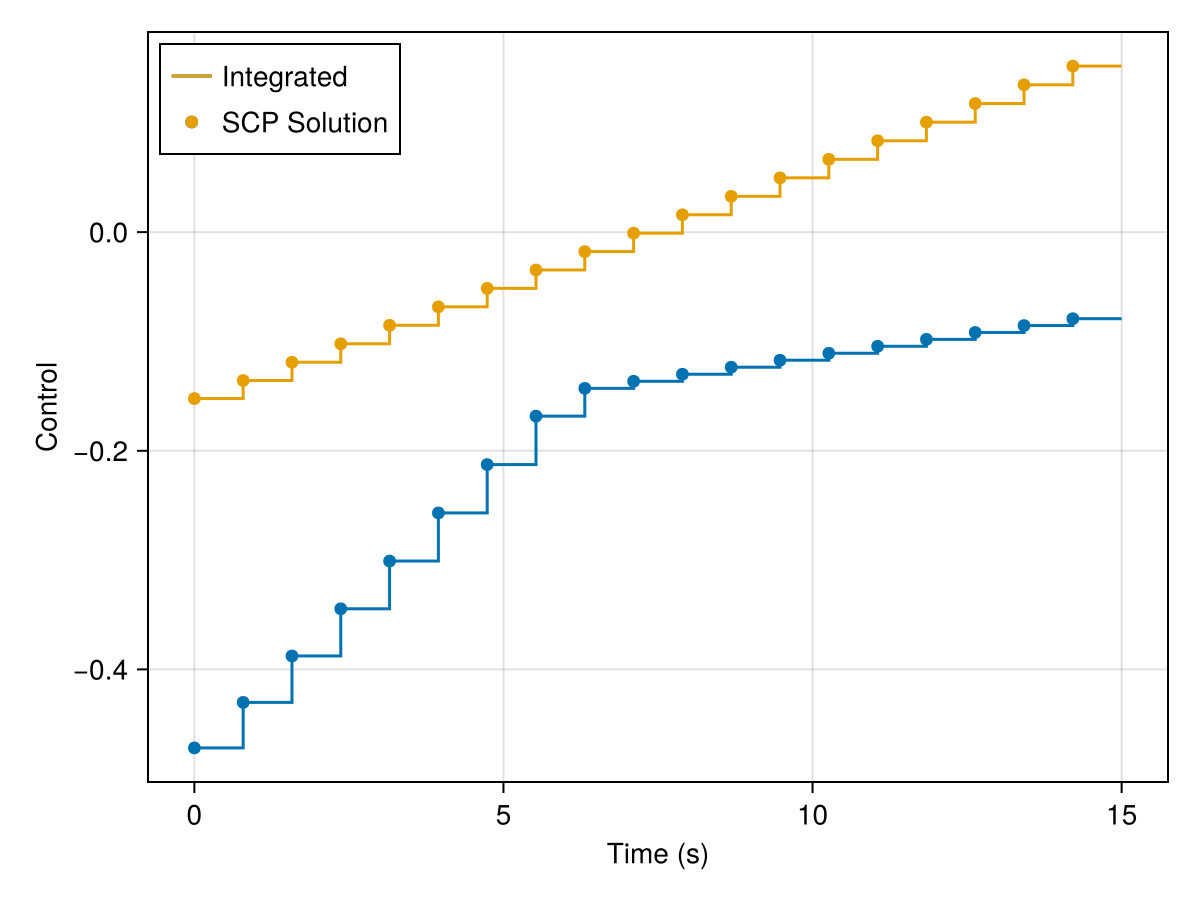

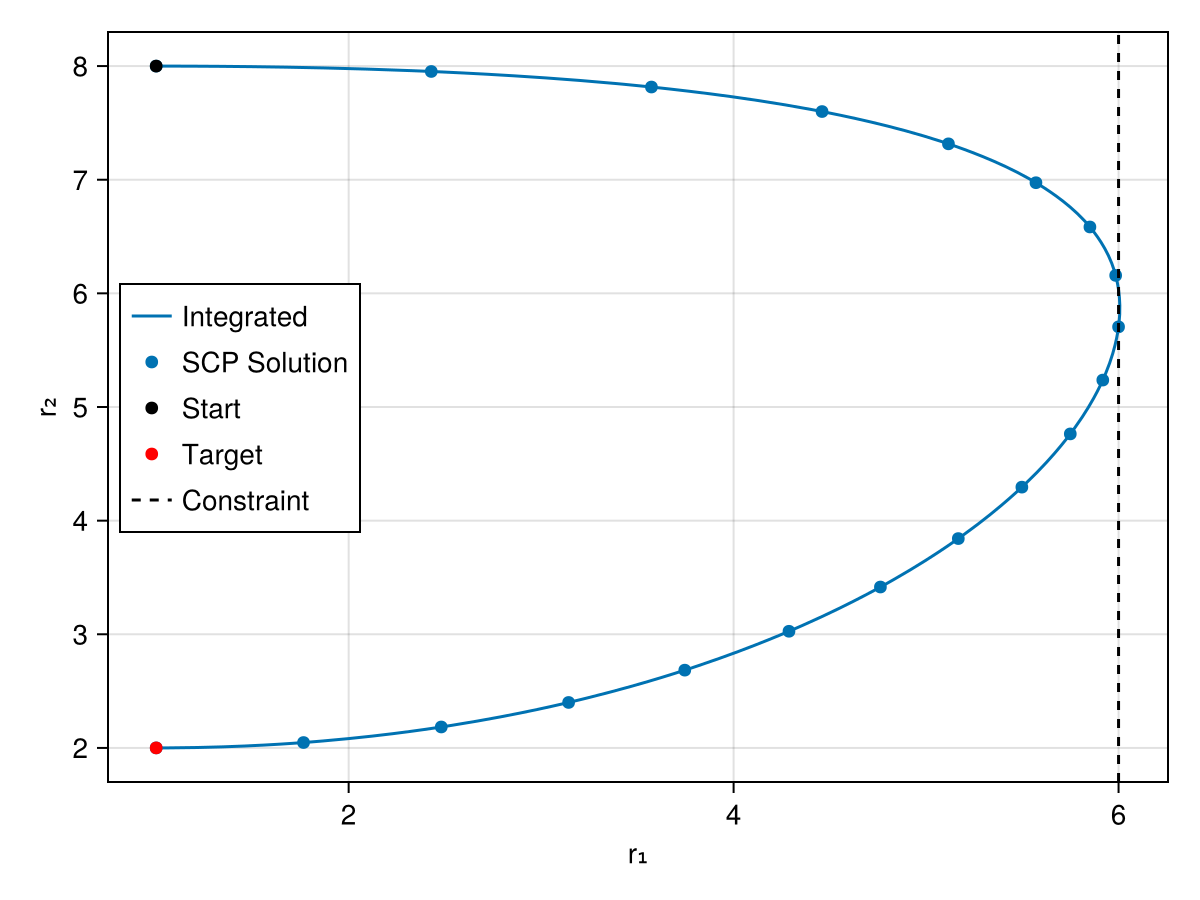

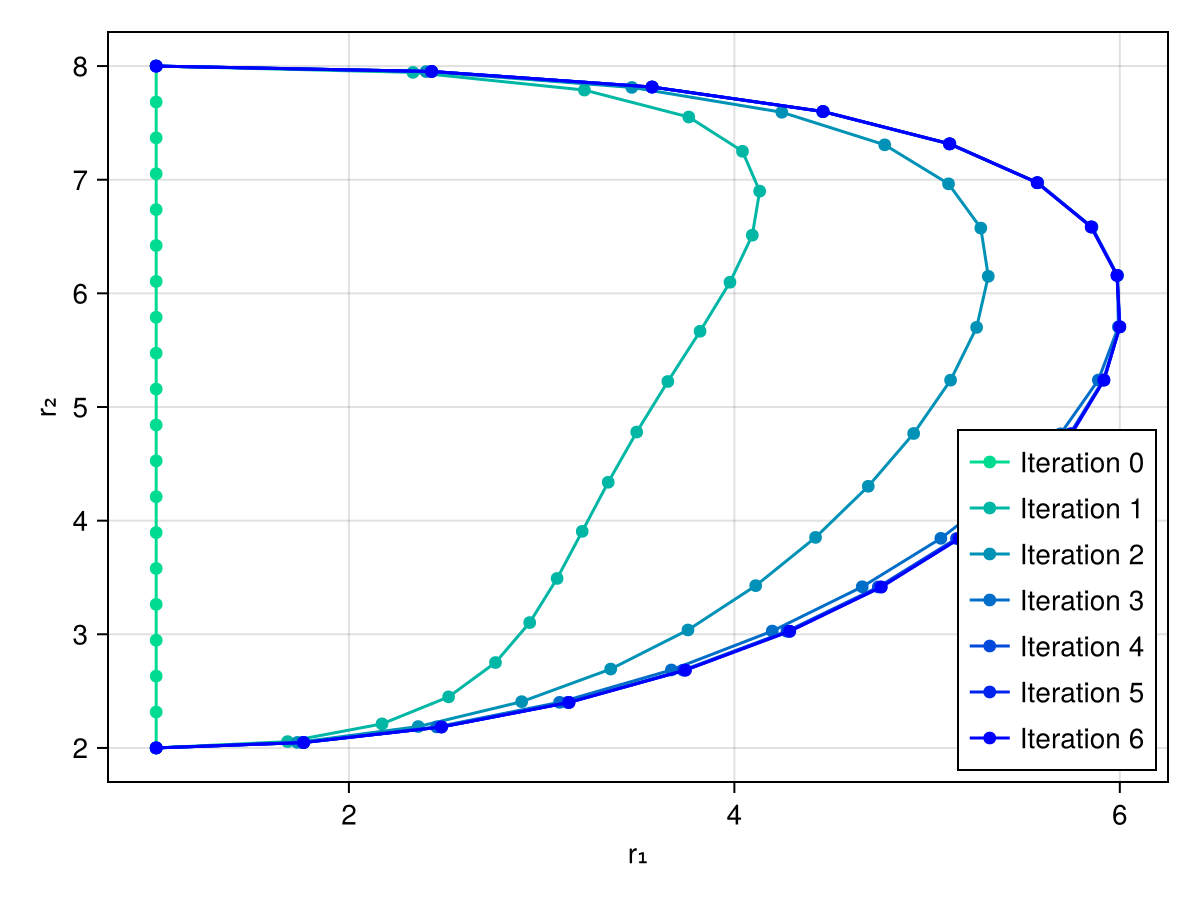

ITERATION 1: res = 2.8569984713152914e-11, dx = 10.695103112339925, elapsed time = 8.294753084
ITERATION 2: res = 1.4340358113115856e-11, dx = 4.2188761427356045, elapsed time = 8.318655958999999
ITERATION 3: res = 1.20222178709751e-11, dx = 2.1707043487376367, elapsed time = 8.329905084
ITERATION 4: res = 1.8620326964727866e-11, dx = 0.1951028122202698, elapsed time = 8.339376918
ITERATION 5: res = 2.499905543425304e-11, dx = 0.03191481065960557, elapsed time = 8.348591543
ITERATION 6: res = 2.0413971016785174e-11, dx = 0.005465139301735729, elapsed time = 8.357898793


In [9]:
## run main code

run_main();